# ECE-6524 / CS-6524 Deep Learning
### Project Assignment 2 

In this assignment, **you will implement the following:**
1. GAN / LSGAN loss functions and training code for MNIST dataset.
2. Train GAN / LSGAN with DCGAN architectures for MNIST dataset.

This assignment is inspired and adapted from UIUC CS498 and Stanford CS231n.
## Submission guideline
1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your Virginia Tech PID below.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of cells).
4. Select Cell -> Run All. This will run all the cells in order.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are displayed correctly there. 
7. Zip all the files along with this notebook (Please don't include the data).
8. Name your PDF file as Assignment2_[YOUR ID NUMBER].
9. Submit your zipped file and the PDF **INDEPENDENTLY**.
10. **PLEASE DO NOT ZIP YOUR DATASET. NOTEBOOK/CODE/PDF ONLY.**

**While you are encouraged to discuss with your peers, <span style="color:blue">all work submitted is expected to be your own.</span> <span style="color:red">If you use any information from other resources (e.g. online materials), you are required to cite it below you VT PID. Any violation will result in a 0 mark for the assignment.</span>**

### Please Write Your VT PID Here: 
### Reference (if any):

# Generative Adversarial Networks (GANs)

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$


# Section 1. Generative Adversarial Networks on MNIST Dataset [55 pts]

In this section, you will need to:
1. Implement two different types of loss functions (GAN / LSGAN) for generative adversarial networks. 
2. Implement training codes for you GAN models.
3. Train and verify your model on MNIST dataset.

Now, let's get started!

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

NOISE_DIM = 100
batch_size = 128

Bce_loss = nn.BCEWithLogitsLoss()

In [0]:
def show_images(images, color=False):
    if color:
        sqrtimg = int(np.ceil(np.sqrt(images.shape[2]*images.shape[3])))
    else:
        images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
        sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))


    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        if color:
            plt.imshow(np.swapaxes(np.swapaxes(img, 0, 1), 1, 2))
        else:
            plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Random Noise
# Generate uniform noise from -1 to 1 with shape [batch_size, dim]
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    to_return = torch.randn((batch_size, dim))
    return to_return/torch.max(to_return)

In [0]:
# set your device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

## Section 1.1. Vanilla GAN loss functions

### Section 1.1.1 GAN Loss [10 pts]
We start from implementing the vanilla GAN loss from the [original GAN paper](https://arxiv.org/pdf/1406.2661.pdf). Specifically, you need to complete the `generator_loss` and `discriminator_loss` in the cell below.

Recalled from the class, the generator loss is written as:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these equations could be silghtly different from what we have seen before. This is because that in Pytorch, our optimize will be *minimizing* the loss functions. As a result, we negate the formulas to match pytorch's behavior.

**HINTS**: You should use the `torch.nn.functional.binary_cross_entropy_with_logits` function to compute the binary cross entropy loss since it is more numerically stable than using a softmax followed by BCE loss. The BCE loss is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$


Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [0]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss.
 
    You should use the stable torch.nn.functional.binary_cross_entropy_with_logits
    loss rather than using a separate softmax function followed by the binary cross
    entropy loss.
 
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
 
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    
    loss = None
    Bce_loss = nn.BCEWithLogitsLoss()
    ####################################
    N = logits_real.size()
    
    true_labels = torch.ones(N).to(device)
    real_image_loss = Bce_loss(logits_real, true_labels) 
    fake_image_loss = Bce_loss(logits_fake, 1 - true_labels) 
    loss = (real_image_loss + fake_image_loss)
    ####################################

    ##########       END      ##########
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss.

    You should use the stable torch.nn.functional.binary_cross_entropy_with_logits
    loss rather than using a separate softmax function followed by the binary cross
    entropy loss.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    loss = None
    ####################################
    N = logits_fake.size()
    true_labels = torch.ones(N).to(device)
    loss = Bce_loss(logits_fake, true_labels)
    ####################################
    
    ##########       END      ##########
    return loss

### Section 1.1.2 Implement Discriminator and Generator models for GAN [10 pts]

#### Discriminator
Our first step is to build a discriminator. Fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms. The architecture is:
 * Flatten the input image dimensions to (batch_size, C*H*W)
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1
 
Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [0]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential(
        
        Flatten(),
        nn.Linear(784, 256),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Linear(256, 256),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Linear(256, 1),    
    )
    return model

#### Generator
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024 
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])

In [0]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    model = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 784),
        nn.Tanh(),
    )
    return model

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


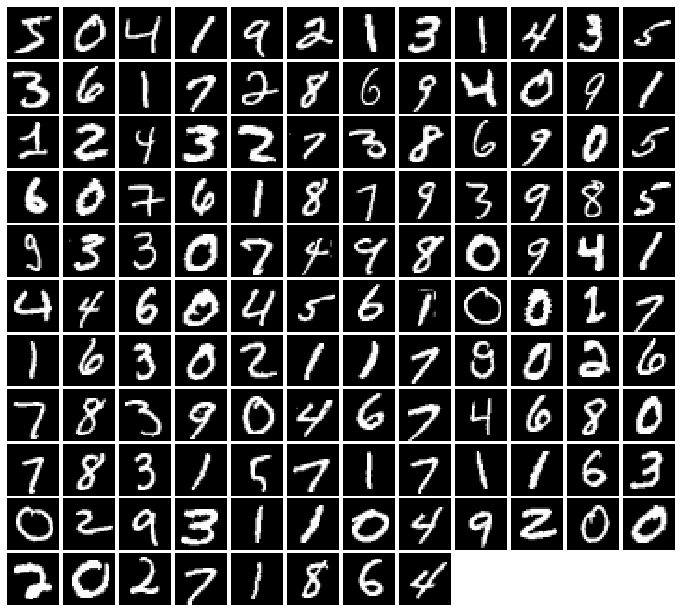

In [8]:
mnist = datasets.MNIST('./MNIST_data', train=True, download=True, transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)

imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Section 1.1.3 Training code [15 pts]
### Training a GAN!

You can't train a model without a proper training code. Implement the GAN training procedure here following the [original GAN paper](https://arxiv.org/pdf/1406.2661.pdf) and the course slides in the cell below. Note that this code would be reused in the subsequent section, so make sure that it is correctly implemented.

In [0]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
 
def train(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250,
              batch_size=128, noise_size=100, num_epochs=10, train_loader=None, device=None):
    """
    Train loop for GAN.

    The loop will consist of two steps: a discriminator step and a generator step.

    (1) In the discriminator step, you should zero gradients in the discriminator
    and sample noise to generate a fake data batch using the generator. Calculate
    the discriminator output for real and fake data, and use the output to compute
    discriminator loss. Call backward() on the loss output and take an optimizer
    step for the discriminator.

    (2) For the generator step, you should once again zero gradients in the generator
    and sample noise to generate a fake data batch. Get the discriminator output
    for the fake data batch and use this to compute the generator loss. Once again
    call backward() on the loss and take an optimizer step.

    You will need to reshape the fake image tensor outputted by the generator to
    be dimensions (batch_size x input_channels x img_size x img_size).

    Use the sample_noise function to sample random noise, and the discriminator_loss
    and generator_loss functions for their respective loss computations

    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    - train_loader: image dataloader
    - device: PyTorch device
    """
    iter_count = 0
    for epoch in range(num_epochs):
        print('EPOCH: ', (epoch+1))
        for x, _ in train_loader:
            
            _, input_channels, img_size, _ = x.shape

            real_images = preprocess_img(x).to(device)  # normalize

            # Store discriminator loss output, generator loss output, and fake image output
            # in these variables for logging and visualization below
            d_error = None
            g_error = None
            fake_images = None
            ####################################
            #        Discriminator step        #
            #         your code here.
            ####################################
            D_solver.zero_grad()
            logits_real = D(real_images).to(device)

            g_fake_seed = sample_noise(batch_size, noise_size).to(device)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28)).to(device)

            d_error = discriminator_loss(logits_real, logits_fake).to(device)
            d_error.backward()        
            D_solver.step()
            ####################################
            #          Generator step          #
            #          your code here.
            ####################################
            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).to(device)
            fake_images = G(g_fake_seed)
            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28)).to(device)
            g_error = generator_loss(gen_logits_fake).to(device)
            g_error.backward()
            G_solver.step()
            ##########       END      ##########
            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_error.item(),g_error.item()))
                disp_fake_images = deprocess_img(fake_images.data)  # denormalize
                imgs_numpy = (disp_fake_images).cpu().numpy()
                show_images(imgs_numpy[0:16], color=input_channels!=1)
                plt.show()
                print()
            iter_count += 1

### Section 1.1.4 Training on MNIST [5 pts]
Run the cell belowe to train your GAN model. You should expect results that resemble the following if your loss function and training loop implementations are correct:

EPOCH:  1
Iter: 0, D: 1.372, G:0.6752


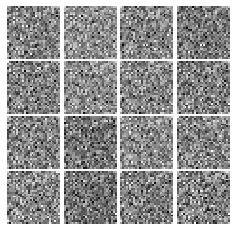


Iter: 250, D: 0.8736, G:1.203


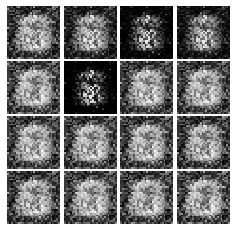


EPOCH:  2
Iter: 500, D: 0.7291, G:1.447


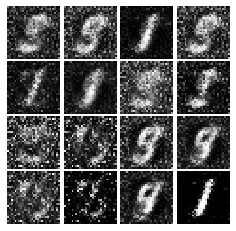


Iter: 750, D: 1.343, G:1.286


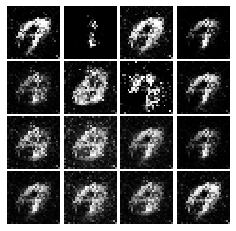


EPOCH:  3
Iter: 1000, D: 1.036, G:1.285


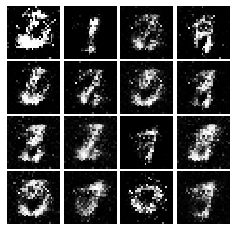


Iter: 1250, D: 0.9633, G:1.054


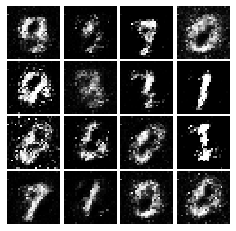


EPOCH:  4
Iter: 1500, D: 1.135, G:1.032


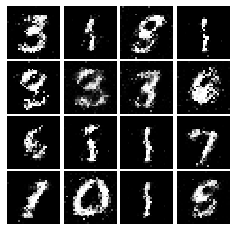


Iter: 1750, D: 1.293, G:1.193


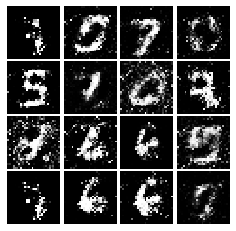


EPOCH:  5
Iter: 2000, D: 1.292, G:0.7512


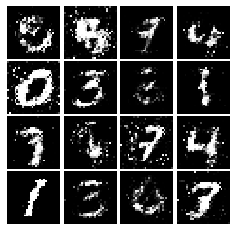


Iter: 2250, D: 1.426, G:0.9846


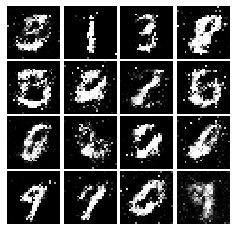


EPOCH:  6
Iter: 2500, D: 1.276, G:0.9388


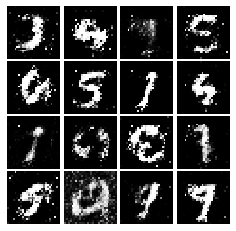


Iter: 2750, D: 1.48, G:0.7044


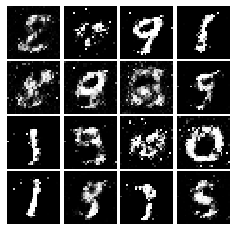


EPOCH:  7
Iter: 3000, D: 1.25, G:0.8612


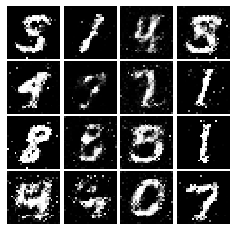


Iter: 3250, D: 1.259, G:1.085


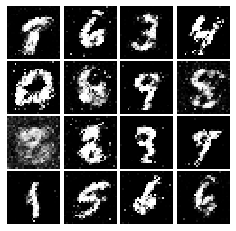


EPOCH:  8
Iter: 3500, D: 1.239, G:1.09


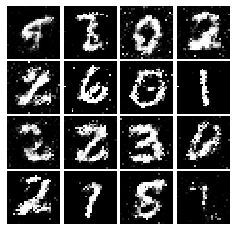


EPOCH:  9
Iter: 3750, D: 1.368, G:0.8877


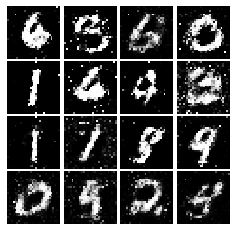


Iter: 4000, D: 1.37, G:0.7159


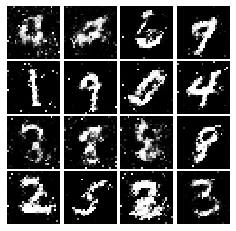


EPOCH:  10
Iter: 4250, D: 1.232, G:0.8368


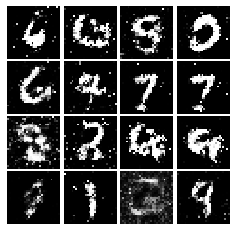


Iter: 4500, D: 1.256, G:0.8415


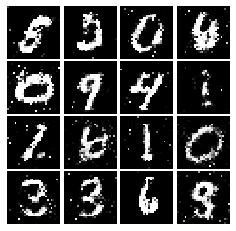

In [10]:
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))
# Run it!
train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000.

## Section 1.2 Least-square GAN Loss
### Section 1.2.1 LSGAN Loss [10 pts]
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$
Fill in the `ls_discriminator_loss` and `ls_generator_loss` in the cell below.

**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [0]:
def ls_discriminator_loss(logits_real, logits_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    loss = None
    ####################################
    N, _ = logits_real.size()
    true_labels = torch.ones(N).to(device)
    loss_real = (0.5*torch.mean(torch.pow(logits_real-true_labels, 2))).to(device)
    loss_fake = (0.5*torch.mean(torch.pow(logits_fake, 2))).to(device)
    loss = (loss_real + loss_fake)
    return loss
    ##########       END      ##########

def ls_generator_loss(logits_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    loss = None
    ####################################
    N, _ = logits_fake.size()
    true_labels = torch.ones(N).to(device)
    loss = (0.5*torch.mean(torch.pow(logits_fake-true_labels, 2))).to(device)
    return loss
    ##########       END      ##########  

### Section 1.2.2 Train LSGAN [5 pts]
Similarly, train your LSGAN on MNIST dataset. You should expect results that resemble the following if your loss function and training loop implementations are correct:

EPOCH:  1
Iter: 0, D: 0.5412, G:0.5208


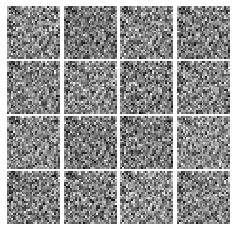


Iter: 250, D: 0.1024, G:0.3694


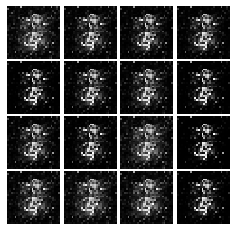


EPOCH:  2
Iter: 500, D: 0.1084, G:0.3751


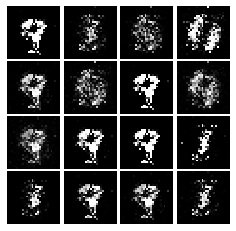


Iter: 750, D: 0.09865, G:0.5211


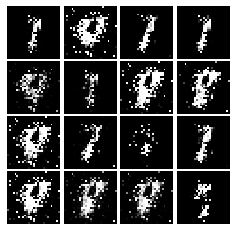


EPOCH:  3
Iter: 1000, D: 0.06924, G:0.4186


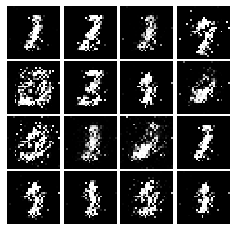


Iter: 1250, D: 0.1598, G:0.7136


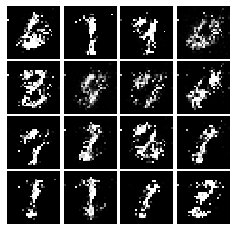


EPOCH:  4
Iter: 1500, D: 0.1302, G:0.2749


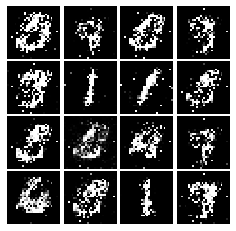


Iter: 1750, D: 0.2574, G:0.2519


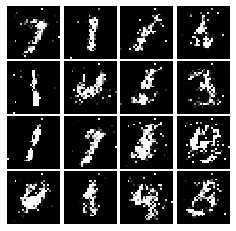


EPOCH:  5
Iter: 2000, D: 0.2091, G:0.1927


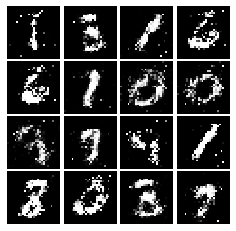


Iter: 2250, D: 0.2773, G:0.2687


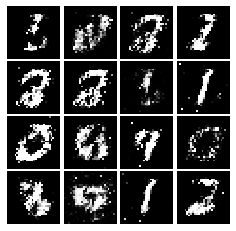


EPOCH:  6
Iter: 2500, D: 0.2269, G:0.1984


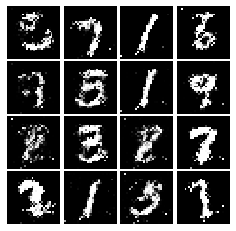


Iter: 2750, D: 0.2456, G:0.1685


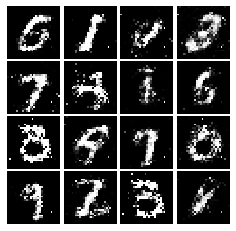


EPOCH:  7
Iter: 3000, D: 0.2282, G:0.1493


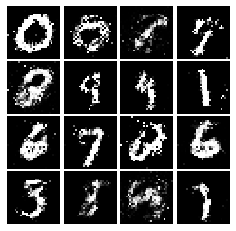


Iter: 3250, D: 0.2109, G:0.171


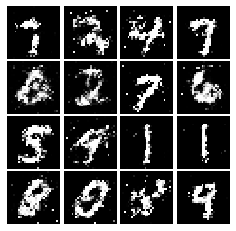


EPOCH:  8
Iter: 3500, D: 0.2328, G:0.168


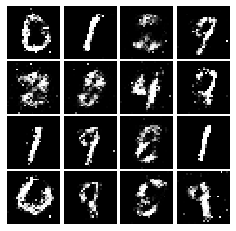


EPOCH:  9
Iter: 3750, D: 0.209, G:0.1758


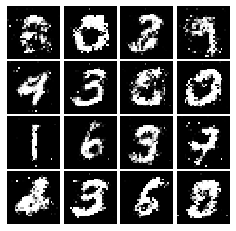


Iter: 4000, D: 0.2407, G:0.1651


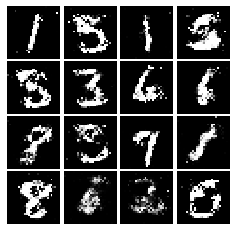


EPOCH:  10
Iter: 4250, D: 0.2192, G:0.1845


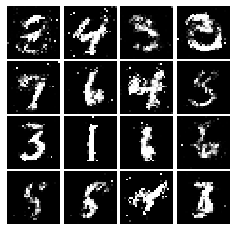


Iter: 4500, D: 0.2248, G:0.1516


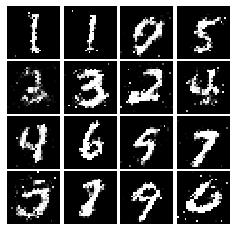

In [12]:
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))
# Run it!
train(D, G, D_optimizer, G_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)

# Section 2. Deeply Convolutional GANs [45 pts]

In this section, you will need to:
1. Implement DCGAN architecture
2. Train it on MNIST dataset for GAN/LSGAN loss function.

# Deeply Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks 

### Section 2.1. DCGAN model architecture [20 pts]
Implement your generator and discriminator model as follows:

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly. 
* Reshape into image tensor
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

In [0]:
def build_dc_classifier():
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
    return nn.Sequential(
        Unflatten(batch_size, 1, 28, 28),
        nn.Conv2d(1, 32, kernel_size=5, stride=1),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, kernel_size=5, stride=1),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.MaxPool2d(2, stride=2),
        Flatten(),
        nn.Linear(1024, 1024),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Linear(1024, 1)   
    )

#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode. 
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* ReLU
* BatchNorm
* Reshape into Image Tensor of shape 7, 7, 128
* Conv2D^T (Transpose): 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* Conv2D^T (Transpose): 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector

In [0]:
def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    return nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 7*7*128),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(7*7*128),
        Unflatten(batch_size, 128, 7, 7),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
        Flatten()
    )

### Section 2.2 Train a DCGAN Model with GAN / LSGAN loss function [15 pts]
Now, train your new model with GAN loss function. Observe the visualized result of your model, and describe what you see.

EPOCH:  1
Iter: 0, D: 1.396, G:1.554


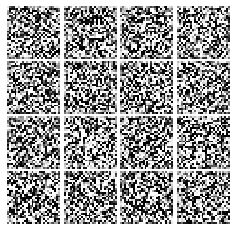


Iter: 250, D: 1.408, G:1.518


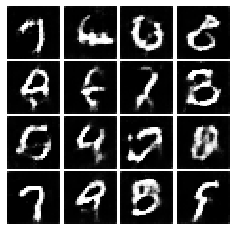


EPOCH:  2
Iter: 500, D: 1.082, G:1.186


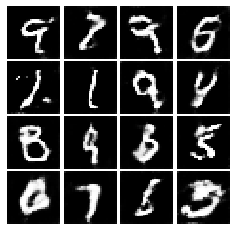


Iter: 750, D: 1.41, G:1.737


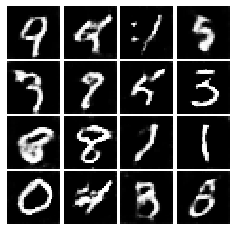


EPOCH:  3
Iter: 1000, D: 1.092, G:1.093


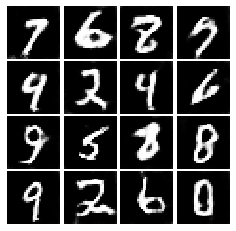


Iter: 1250, D: 1.092, G:0.9046


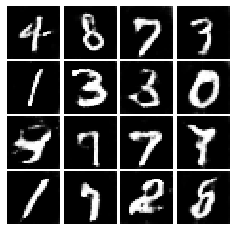


EPOCH:  4
Iter: 1500, D: 1.166, G:1.014


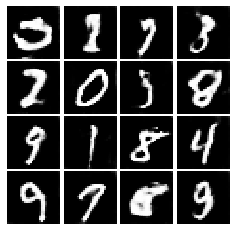


Iter: 1750, D: 0.9798, G:1.214


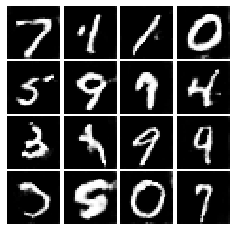


EPOCH:  5
Iter: 2000, D: 1.113, G:1.038


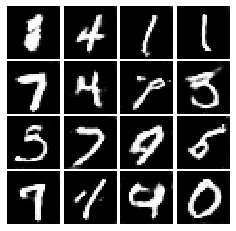


Iter: 2250, D: 1.035, G:0.8916


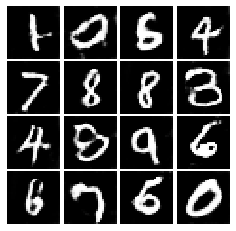


EPOCH:  6
Iter: 2500, D: 1.01, G:1.053


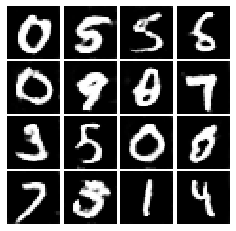


Iter: 2750, D: 1.059, G:1.329


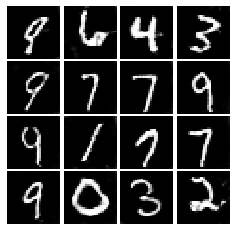


EPOCH:  7
Iter: 3000, D: 0.9381, G:1.534


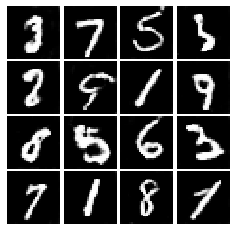


Iter: 3250, D: 1.005, G:1.547


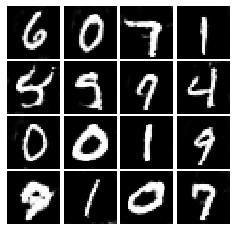


EPOCH:  8
Iter: 3500, D: 0.9818, G:0.938


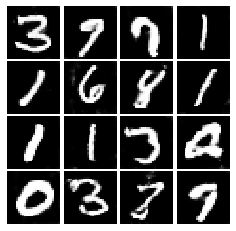


EPOCH:  9
Iter: 3750, D: 0.9545, G:1.376


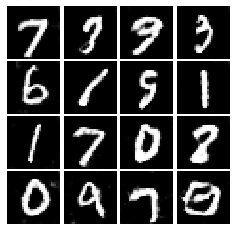


Iter: 4000, D: 1.048, G:1.29


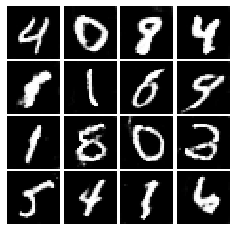


EPOCH:  10
Iter: 4250, D: 1.06, G:1.141


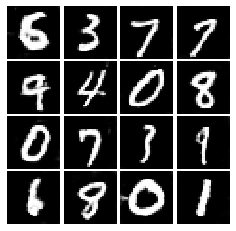


Iter: 4500, D: 0.8695, G:1.217


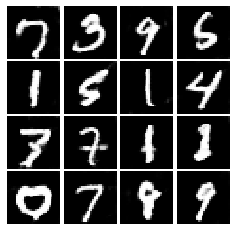

In [15]:
# YOUR TRAINING CODE HERE
D = build_dc_classifier().to(device)
G = build_dc_generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))
# Run it!

train(D, G, D_optimizer, G_optimizer,discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

Now, train your DCGAN model with LSGAN loss function. Observe the visualized result of your model, and describe what you see.

EPOCH:  1
Iter: 0, D: 0.5598, G:1.18


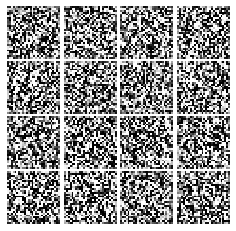


Iter: 250, D: 0.2395, G:0.1574


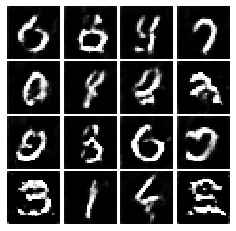


EPOCH:  2
Iter: 500, D: 0.1988, G:0.2445


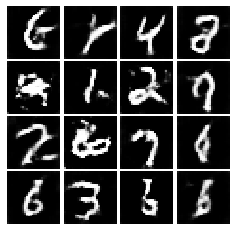


Iter: 750, D: 0.2139, G:0.1958


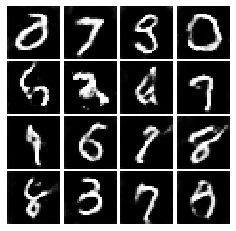


EPOCH:  3
Iter: 1000, D: 0.2093, G:0.1873


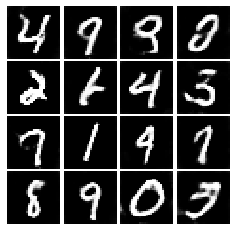


Iter: 1250, D: 0.1949, G:0.2106


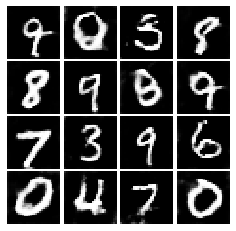


EPOCH:  4
Iter: 1500, D: 0.208, G:0.1725


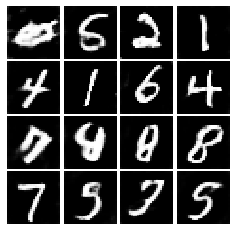


Iter: 1750, D: 0.1991, G:0.2125


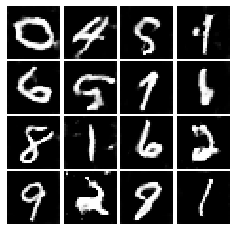


EPOCH:  5
Iter: 2000, D: 0.2044, G:0.1623


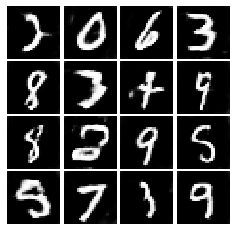


Iter: 2250, D: 0.2033, G:0.1823


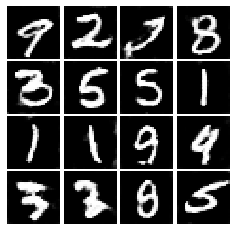


EPOCH:  6
Iter: 2500, D: 0.1827, G:0.2035


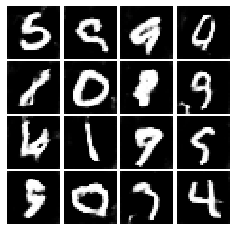


Iter: 2750, D: 0.1969, G:0.1671


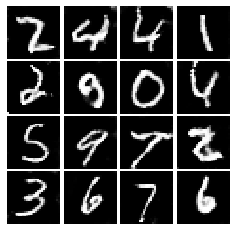


EPOCH:  7
Iter: 3000, D: 0.1785, G:0.2389


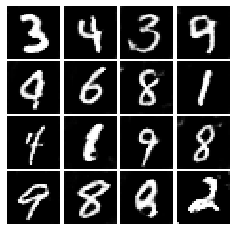


Iter: 3250, D: 0.1656, G:0.2325


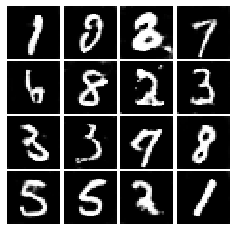


EPOCH:  8
Iter: 3500, D: 0.1906, G:0.1386


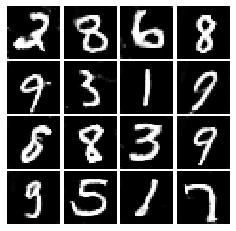


EPOCH:  9
Iter: 3750, D: 0.1837, G:0.3358


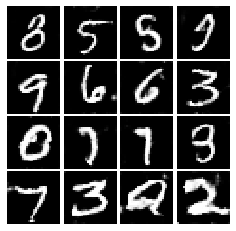


Iter: 4000, D: 0.2096, G:0.2506


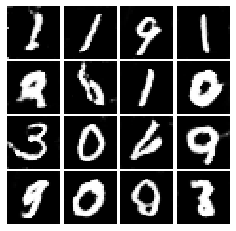


EPOCH:  10
Iter: 4250, D: 0.1718, G:0.232


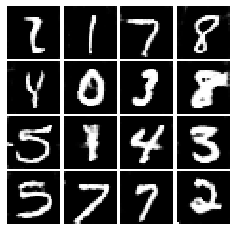


Iter: 4500, D: 0.1585, G:0.2305


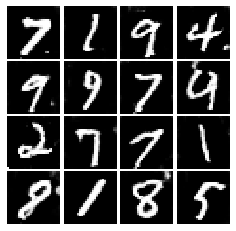

In [16]:
# YOUR TRAINING CODE HERE
D = build_dc_classifier().to(device)
G = build_dc_generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))
# Run it!

train(D, G, D_optimizer, G_optimizer,ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)